# Fake Voice Detection

## Temporal Convolutional Model

### Environment Setup Process

In [ ]:
# Installation
!git clone https://github.com/dessa-oss/fake-voice-detection.git
%cd /content/fake-voice-detection/
!pip install -r '/content/fake-voice-detection/code/requirements.txt'

In [ ]:
# Load data
!wget https://asv-audio-data-atlas.s3.amazonaws.com/realtalk.zip
!unzip realtalk.zip

In [ ]:
# Checking files
from glob import glob
fake_audio = glob('realtalk/fake/*.wav')
real_audio = glob('realtalk/real/*.wav')

import IPython
IPython.display.Audio(fake_audio[0])

In [ ]:
# Load pretrained model
%cd /content/fake-voice-detection/code
!mkdir fitted_objects
%cd fitted_objects
!wget https://asv-audio-data-atlas.s3.amazonaws.com/saved_model_240_8_32_0.05_1_50_0_0.0001_100_156_2_True_True_fitted_objects.h5

In [ ]:
# # Loading testing audio file
%cd /content/fake-voice-detection/data
!mkdir inference_data
%cd inference_data
!mkdir unlabeled
!cp /content/fake-voice-detection/realtalk/fake/JREa631-0030.wav /content/fake-voice-detection/data/inference_data/unlabeled
!cp /content/realtalk/fake/JREa631-0030.wav /content/fake-voice-detection/data/inference_data/unlabeled
%cd /content/fake-voice-detection/code/

In [ ]:
import os
import numpy as np
import subprocess
import sys
sys.path.append('/content/fake-voice-detection/code')
from sklearn.metrics import f1_score, accuracy_score
from utils import *

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
def detect_deepfake(file_path='/content/fake-voice-detection/data/inference_data', mode='unlabeled'):
  data_dir = file_path
  mode = mode  # real, fake, or unlabeled
  pretrained_model_name = 'saved_model_240_8_32_0.05_1_50_0_0.0001_100_156_2_True_True_fitted_objects.h5'
  print(f"Loading inference data from {os.path.join(data_dir,mode)}")
  print(f"Loading pretrained model {pretrained_model_name}")

  # preprocess the files
  processed_data = preprocess_from_ray_parallel_inference(data_dir, mode, use_parallel=True)
  processed_data = sorted(processed_data, key = lambda x: len(x[0]))

  # Load trained model
  discriminator = Discriminator_Model(load_pretrained=True, saved_model_name=pretrained_model_name, real_test_mode=False)

  # Do inference
  if mode == 'unlabeled':
      # Visualize the preprocessed data
      plot_spectrogram(processed_data[0], path=os.path.join(file_path,'visualize_inference_spectrogram.png'))

      real_proba = discriminator.predict_labels(processed_data, 
                                                raw_prob=True, 
                                                batch_size=20)[0][0]
  else:
      features = [x[0] for x in processed_data]
      labels = [x[1] for x in processed_data]
      preds = discriminator.predict_labels(features, threshold=0.5, batch_size=1)
      print(f"Accuracy on data set: {accuracy_score(labels, preds)}")

      all_filenames = sorted(os.listdir(os.path.join(data_dir, mode)))

      if mode == 'real':
          # True Positive Examples
          ind_tp = np.equal((preds + labels).astype(int), 2)
          ind_tp = np.argwhere(ind_tp == True).reshape(-1, )
          tp_filenames = [all_filenames[i] for i in ind_tp]
          print(f'correctly predicted filenames: {tp_filenames}')

          # False Negative Examples
          ind_fn = np.greater(labels, preds)
          ind_fn = np.argwhere(ind_fn == True).reshape(-1, )
          fn_filenames = [all_filenames[i] for i in ind_fn]
          print(f'real clips classified as fake: {fn_filenames}')
      elif mode == 'fake':
          # True Negative Examples
          ind_tn = np.equal((preds + labels).astype(int), 0)
          ind_tn = np.argwhere(ind_tn == True).reshape(-1, )
          tn_filenames = [all_filenames[i] for i in ind_tn]
          print(f'correctly predicted filenames: {tn_filenames}')

          # False Positive Examples
          ind_fp = np.greater(preds, labels)
          ind_fp = np.argwhere(ind_fp == True).reshape(-1, )
          fp_filenames = [all_filenames[i] for i in ind_fp]
          print(f'fake clips classified as real: {fp_filenames}')

  return real_proba

### Detect DeepFake

In [ ]:
# Step 1: Set the location where your files are stored
my_file_path = '/content/fake-voice-detection/data/inference_data/'

# Step 2: Run the model
real_probability = detect_deepfake(my_file_path)

100%|██████████| 1/1 [00:00<00:00, 100.70it/s]

Loading inference data from /content/fake-voice-detection/data/inference_data/unlabeled
Loading pretrained model saved_model_240_8_32_0.05_1_50_0_0.0001_100_156_2_True_True_fitted_objects.h5


[[0.00440623]]


In [ ]:
# Step 3: Get the result
print("The probability of the clip being real is: {:.2%}".format(real_probability))

The probability of the clip being real is: 0.44%


## GMM-UGB and CVAE model

In [ ]:
# Installation
%tensorflow_version 1.x
!git clone https://github.com/kstoneriv3/Fake-Voice-Detection.git
!pip install --user -r requirements.txt

TensorFlow 1.x selected.


In [ ]:
%cd Fake-Voice-Detection/

/content/Fake-Voice-Detection


In [ ]:
# Download and unzip datasets and pretrained models
!python ./src/download.py

downloading dataset ...
Unzipping...Done.
Done.
downloading models ...
Unzipping...

In [ ]:
# Split the raw speech
!python ./src/split_normalize_raw_speech.py

splitting raw speech data ...
is finished.


In [ ]:
!zip /content/Fake-Voice-Detection/data

In [ ]:
# CycleGAN Voice Conversion

# Train the Voice Conversion Model
# !python ./src/conversion/train.py --model_dir='./model/conversion/pretrained'

# Convert the source speaker's voice
!python ./src/conversion/convert.py --model_dir='./model/conversion/pretrained'

In [ ]:
# GMM-UBG verification

# Train the GMM based verification system and Plot the scores
!python ./src/verification_gmm/train_and_plot.py

In [ ]:
# compute AUC converted samples of every 50 epoch
!python ./src/verification_gmm/compute_auc.py

In [ ]:
# Convolutional VAE

# Train the CVAE based verification system and Plot the scores
!python ./src/verification_cvae/cvae_verification.py

## Audio encoding based detection

In [ ]:
# Installation
!pip install resemblyzer
!git clone https://github.com/resemble-ai/Resemblyzer.git
import sys
%cd Resemblyzer

     |████████████████████████████████| 1.8MB 3.4MB/s 
[youtube] cQ54GDm1eL0: Downloading webpage
[download] Destination: downloaded.m4a
[download] 100% of 1.12MiB in 00:00
[ffmpeg] Correcting container in "downloaded.m4a"
[ffmpeg] Destination: downloaded.wav
Deleting original file downloaded.m4a (pass -k to keep)


Preprocessing wavs: 100%|██████████| 18/18 [01:10<00:00,  3.94s/ utterances]


Loaded the voice encoder model on cpu in 0.04 seconds.


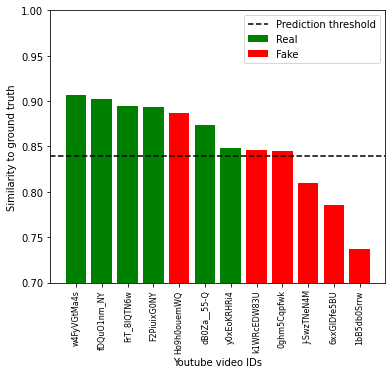

In [ ]:
# Similarity Matching
from resemblyzer import preprocess_wav, VoiceEncoder
from demo_utils import *
from pathlib import Path
from tqdm import tqdm
import numpy as np


# Load data
!pip install -q youtube-dl
YOUTUBE_ID = ['cQ54GDm1eL0']
for index,uid in enumerate(YOUTUBE_ID):
  !youtube-dl --extract-audio --audio-format wav --output "downloaded.%(ext)s" https://www.youtube.com/watch\?v\={uid}
  !ffmpeg -loglevel panic -y -i downloaded.wav -acodec pcm_s16le -ac 1 -ar 16000 obamaFake_{index}.wav

## Load and preprocess the audio
data_dir = Path("audio_data", "donald_trump")
wav_fpaths = list(data_dir.glob("**/*.mp3"))
wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
        tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]

## Compute the embeddings
encoder = VoiceEncoder()
embeds = np.array([encoder.embed_utterance(wav) for wav in wavs])
speakers = np.array([fpath.parent.name for fpath in wav_fpaths])
names = np.array([fpath.stem for fpath in wav_fpaths])

# Take 6 real embeddings at random, and leave the 6 others for testing
gt_indices = np.random.choice(*np.where(speakers == "real"), 6, replace=False) 
mask = np.zeros(len(embeds), dtype=np.bool)
mask[gt_indices] = True
gt_embeds = embeds[mask]
gt_names = names[mask]
gt_speakers = speakers[mask]
embeds, speakers, names = embeds[~mask], speakers[~mask], names[~mask]

## Compare all embeddings against the ground truth embeddings, and compute the average similarities.
scores = (gt_embeds @ embeds.T).mean(axis=0)

# Order the scores by decreasing order
sort = np.argsort(scores)[::-1]
scores, names, speakers = scores[sort], names[sort], speakers[sort]

## Plot the scores
fig, _ = plt.subplots(figsize=(6, 6))
indices = np.arange(len(scores))
plt.axhline(0.84, ls="dashed", label="Prediction threshold", c="black")
plt.bar(indices[speakers == "real"], scores[speakers == "real"], color="green", label="Real")
plt.bar(indices[speakers == "fake"], scores[speakers == "fake"], color="red", label="Fake")
plt.legend()
plt.xticks(indices, names, rotation="vertical", fontsize=8)
plt.xlabel("Youtube video IDs")
plt.ylim(0.7, 1)
plt.ylabel("Similarity to ground truth")
fig.subplots_adjust(bottom=0.25)
plt.show()

Preprocessing wavs: 100%|██████████| 251/251 [01:06<00:00,  3.75 utterances/s]


Loaded the voice encoder model on cpu in 0.01 seconds.


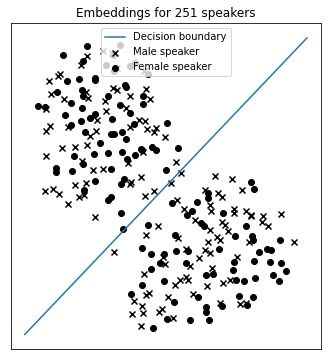

In [ ]:
# Embedding Visualization
from sklearn.linear_model import LogisticRegression 
from resemblyzer import preprocess_wav, VoiceEncoder
from demo_utils import *
from pathlib import Path
from tqdm import tqdm
import numpy as np

## Gather a single utterance per speaker
data_dir = Path("audio_data", "librispeech_train-clean-100")
wav_fpaths = list(data_dir.glob("*.flac"))
speakers = [fpath.stem.split("-")[0] for fpath in wav_fpaths]
wavs = [preprocess_wav(wav_fpath) for wav_fpath in \
        tqdm(wav_fpaths, "Preprocessing wavs", len(wav_fpaths), unit=" utterances")]

# Get the sex of each speaker from the metadata file
with data_dir.joinpath("SPEAKERS.TXT").open("r") as f:
    sexes = dict(l.replace(" ", "").split("|")[:2] for l in f if not l.startswith(";"))
markers = ["x" if sexes[speaker] == "M" else "o" for speaker in speakers]
colors = ["black"] * len(speakers)


## Compute the embeddings
encoder = VoiceEncoder()
utterance_embeds = np.array(list(map(encoder.embed_utterance, wavs)))


## Project the embeddings in 2D space. 
_, ax = plt.subplots(figsize=(6, 6))
# Passing min_dist=1 to UMAP will make it so the projections don't necessarily need to fit in 
# clusters, so that you can have a better idea of what the manifold really looks like. 
projs = plot_projections(utterance_embeds, speakers, ax, colors, markers, False,
                         min_dist=1)
ax.set_title("Embeddings for %d speakers" % (len(speakers)))
ax.scatter([], [], marker="x", c="black", label="Male speaker")
ax.scatter([], [], marker="o", c="black", label="Female speaker")

# Separate the data by the sex
classifier = LogisticRegression(solver="lbfgs")
classifier.fit(projs, markers)
x = np.linspace(*ax.get_xlim(), num=200)
y = -(classifier.coef_[0, 0] * x + classifier.intercept_) / classifier.coef_[0, 1]
mask = (y > ax.get_ylim()[0]) & (y < ax.get_ylim()[1])
ax.plot(x[mask], y[mask], label="Decision boundary")

ax.legend()
plt.show()

In [ ]:
# Print Embeddings
from resemblyzer import VoiceEncoder, preprocess_wav
from pathlib import Path
import numpy as np

fpath = Path("/content/Resemblyzer/obamaFake_0.wav")
wav = preprocess_wav(fpath)

encoder = VoiceEncoder()
embed = encoder.embed_utterance(wav)
np.set_printoptions(precision=3, suppress=True)
print(embed)

Loaded the voice encoder model on cpu in 0.01 seconds.
[0.111 0.004 0.02  0.    0.089 0.004 0.014 0.178 0.008 0.009 0.146 0.112
 0.057 0.001 0.014 0.    0.176 0.    0.009 0.052 0.005 0.032 0.    0.
 0.    0.047 0.014 0.009 0.    0.    0.157 0.064 0.    0.096 0.08  0.001
 0.006 0.064 0.048 0.028 0.002 0.    0.071 0.247 0.005 0.    0.058 0.059
 0.002 0.    0.    0.005 0.001 0.    0.008 0.024 0.028 0.    0.007 0.007
 0.    0.    0.001 0.043 0.015 0.    0.119 0.    0.002 0.039 0.129 0.108
 0.    0.102 0.    0.    0.    0.11  0.001 0.084 0.043 0.006 0.161 0.173
 0.001 0.009 0.147 0.042 0.    0.087 0.1   0.    0.    0.    0.067 0.
 0.031 0.    0.    0.    0.007 0.001 0.133 0.05  0.043 0.034 0.021 0.027
 0.041 0.09  0.    0.    0.012 0.123 0.029 0.    0.008 0.094 0.163 0.003
 0.061 0.084 0.056 0.116 0.14  0.173 0.017 0.1   0.098 0.    0.    0.
 0.065 0.161 0.103 0.107 0.008 0.001 0.052 0.    0.003 0.009 0.029 0.028
 0.049 0.009 0.022 0.    0.102 0.001 0.022 0.01  0.    0.015 0.    0.125
 0.  

In [ ]:
# Comparing Voice Similarity

# Load data - Obama and Modi voice
!pip install -q youtube-dl
YOUTUBE_ID = ['y7hddyiR47k','avzJdPkRX_4']
!youtube-dl --extract-audio --audio-format wav --output "downloaded.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID[0]}
!ffmpeg -loglevel panic -y -i downloaded.wav -acodec pcm_s16le -ac 1 -ar 16000 obama.wav
!youtube-dl --extract-audio --audio-format wav --output "downloaded.%(ext)s" https://www.youtube.com/watch\?v\={YOUTUBE_ID[1]}
!ffmpeg -loglevel panic -y -i downloaded.wav -acodec pcm_s16le -ac 1 -ar 16000 modi.wav

[youtube] y7hddyiR47k: Downloading webpage
[download] Destination: downloaded.webm
[download] 100% of 2.23MiB in 00:00
[ffmpeg] Destination: downloaded.wav
Deleting original file downloaded.webm (pass -k to keep)
[youtube] avzJdPkRX_4: Downloading webpage
[download] Destination: downloaded.webm
[download] 100% of 3.01MiB in 00:00
[ffmpeg] Destination: downloaded.wav
Deleting original file downloaded.webm (pass -k to keep)


In [ ]:
from resemblyzer import preprocess_wav, VoiceEncoder
from demo_utils import *
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

encoder = VoiceEncoder()

Loaded the voice encoder model on cpu in 0.01 seconds.


In [ ]:
fpath = Path('/content/Resemblyzer/obama.wav')
wav1 = preprocess_wav(fpath)
fpath = Path('/content/Resemblyzer/modi.wav')
wav2 = preprocess_wav(fpath)

encoder = VoiceEncoder()
embeds_a = encoder.embed_utterance(wav1)
embeds_b = encoder.embed_utterance(wav2)
print("Shape of embeddings: %s" % str(embeds_a.shape))

utt_sim_matrix = np.inner(embeds_a, embeds_b)

Loaded the voice encoder model on cpu in 0.01 seconds.
Shape of embeddings: (256,)
